This is my project for computational intelligence based on kaggle dataset of monkeys.

Import packages

In [17]:
import os
from pathlib import Path
import cv2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.python.keras.models import Sequential
from keras.utils import np_utils

%matplotlib inline

Set data folders

In [18]:
data_folder = 'data'
training_directory = os.path.join(data_folder, 'training', 'training')
test_directory = os.path.join(data_folder, 'validation', 'validation')
labels_file = os.path.join(data_folder, 'monkey_labels.txt')

Read labels

In [19]:
labels_df = pd.read_csv(labels_file)
labels_df = labels_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
labels_df.columns = labels_df.columns.str.strip()
labels = labels_df['Common Name']

Read images from files

In [20]:
def convert_image_to_vector(input_image, size=(32, 32)):
    resized_image = cv2.resize(input_image, size)
    return resized_image


def convert_image_to_vector_rgb(input_image, size=(32, 32)):
    resized_image = cv2.resize(input_image, size)
    img_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    return img_rgb


def convert_image_to_vector_cubic(input_image, size=(32, 32)):
    resized_image = cv2.resize(input_image, size, interpolation=cv2.INTER_CUBIC)
    return resized_image


def convert_image_to_vector_both(input_image, size=(32, 32)):
    resized_image = cv2.resize(input_image, size, interpolation=cv2.INTER_CUBIC)
    img_rgb_cubic = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    return img_rgb_cubic


def normalize(input_image):
    mean, std = input_image.mean(), input_image.std()
    input_image = (input_image - mean) / std
    return input_image


def process_image(file):
     image_file = cv2.imread(file)
     image_pixels = convert_image_to_vector_both(image_file, size=(32, 32))
     image_pixels = normalize(image_pixels)
     image_label = file.split(os.path.sep)[-2]
     return image_pixels, image_label

In [21]:
training_images = []
training_images_knn = []
training_labels = []

for path in Path(training_directory).rglob('*.jpg'):
     image, label = process_image(str(path))
     training_images.append(image)
     training_images_knn.append(image.flatten())

     training_labels.append(label)

test_images = []
test_images_knn = []
test_labels = []

for path in Path(test_directory).rglob('*.jpg'):
     image, label = process_image(str(path))
     test_images.append(image)
     test_labels.append(label)
     test_images_knn.append(image.flatten())


0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object


/home/marcin/studiowanko/computational-intelligence/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


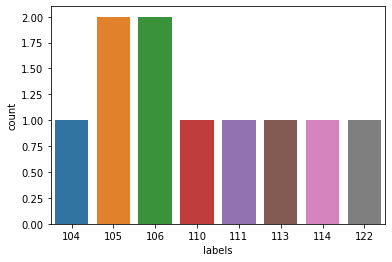

In [22]:
df = pd.DataFrame()
df["labels"]=training_labels
lab = df['labels']
counts = lab.value_counts()
sns.countplot(counts)
print(labels)

In [23]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_images_knn = np.array(test_images_knn)

training_images = np.array(training_images)
training_labels = np.array(training_labels)
training_images_knn = np.array(training_images_knn)

num_classes = len(np.unique(training_labels))
label_encoder = LabelEncoder()
training_labels = label_encoder.fit_transform(training_labels)
test_labels = label_encoder.fit_transform(test_labels)
test_labels = np_utils.to_categorical(test_labels, num_classes)
training_labels = np_utils.to_categorical(training_labels, num_classes)

In [24]:
model = KNeighborsClassifier(n_neighbors=7)
model.fit(training_images_knn, training_labels)
acc = model.score(test_images_knn, test_labels)
print("[INFO] histogram accuracy: {:.2f}%".format(acc * 100))


[INFO] histogram accuracy: 16.91%


Prepare data

In [25]:
training_images = training_images.astype('float32')
test_images = test_images.astype('float32')
# Only needed when flattening the image befores
# training_images = training_images.reshape(-1, 32, 32, 3)
# test_images = test_images.reshape(-1, 32, 32, 3)
# normalizing the data to help with the training

In [26]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# model.compile(
#     loss='categorical_crossentropy',
#     optimizer='rmsprop',
#     metrics=['accuracy']
# )
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 64)         

In [27]:
checkpoint_filepath = 'checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

model.fit(training_images, training_labels, epochs=50, callbacks=[model_checkpoint_callback])
# model.fit(training_images, training_labels, epochs=30)
model.load_weights(checkpoint_filepath)

Epoch 1/50
35/35 [==============================] - 1s 22ms/step - loss: 2.2987 - accuracy: 0.1286

Test accuracy

In [28]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

9/9 - 0s - loss: 1.8079 - accuracy: 0.6765

Test accuracy: 0.6764705777168274


Test on one image

In [29]:
n = 200
test_image = test_images[n]
test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image, batch_size=1)
print(labels[np.argmax(prediction)])
print(labels)

patas_monkey
0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object
